# iFood CRM Data Analyst Case

### Description

The objective of the team is to build a predictive model that will produce the highest profit for the
next direct marketing campaign, scheduled for the next month. 
The new campaign, sixth, aims at
selling a new gadget to the Customer Database. 
To build the model, a pilot campaign involving **2.240 customers** was carried out. 
The customers were selected at random and contacted by phone regarding the acquisition of the gadget. 
During the following months, customers who bought the offer were properly labeled. 
The total cost of the sample campaign was 6.720MU and the revenue generated by the customers who accepted the offer was 3.674MU. 
Globally the campaign had a profit of -3.046MU. 
The success rate of the campaign was 15%. 

The objective is of the team is to develop a model that predicts customer behavior and to apply it to the rest of the customer base.
Hopefully the model will allow the company to cherry pick the customers that are most likely to
purchase the offer while leaving out the non-respondents, making the next campaign highly
profitable. Moreover, other than maximizing the profit of the campaign, the CMO is interested in
understanding to study the characteristic features of those customers who are willing to buy the
gadget.

### Key Objectives are:

1. Explore the data – don’t just plot means and counts. Provide insights, define cause and
effect. Provide a better understanding of the characteristic features of respondents;
2. Propose and describe a customer segmentation based on customers behaviors;
3. Create a predictive model which allows the company to maximize the profit of the next
marketing campaign.
4. Whatever else you think is necessary.

### Deliverables:

1. Data Exploration;
2. Segmentation;
3. Classification Model;
4. A short business presentation.

### Data Dictionary and Notes

At the botton of the notebook

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import scipy.stats as ss
from scipy.stats import chi2_contingency

In [262]:
# Load the main dataset
raw_ifood_df = pd.read_csv('ml_project1_data.csv')
raw_ifood_df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## Customer Profile Analysis

These are the columns related to Customer Profile Information 

| categorical 	     | numerical 	            |
|-----------	     |-----------	            |
|Education - ordinal | Income  - continuous  	|
|Marital - nominal   | Kidhome  - discrete 	    |
|                    | Teenhome - discrete 	    |
|      	             | dtCustomer - interval    |
|                    | yearbirth - interval     |



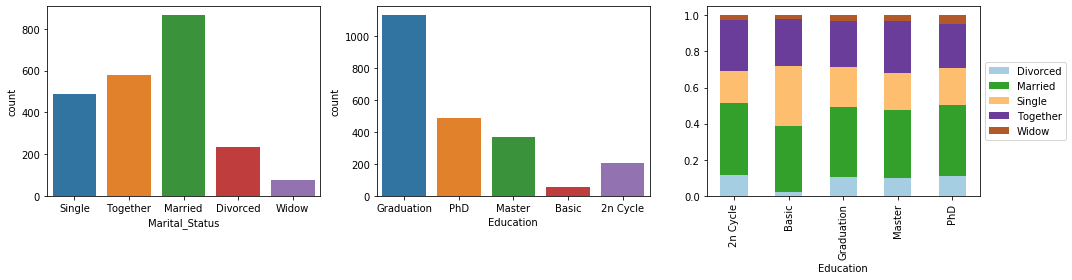

In [49]:
# Taking a look at the categorical variables
fig, ax = plt.subplots(1,3, figsize=(15,4))
sns.countplot(raw_ifood_df['Marital_Status'], ax=ax[0])
sns.countplot(raw_ifood_df['Education'], ax=ax[1])
df_plot = raw_ifood_df.groupby(['Marital_Status', 'Education']).size().reset_index().pivot(columns='Marital_Status', index='Education', values=0)
df_plot.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax[2],  colormap='Paired')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
fig.show()

In [39]:
df_plot

Marital_Status  Divorced  Married  Single  Together  Widow
Education                                                 
2n Cycle              23       81      37        57      5
Basic                  1       20      18        14      1
Graduation           119      433     254       286     35
Master                37      138      77       106     12
PhD                   52      192     101       117     24


### Some transformations are required:

* yearbirth -> customer_age: in years
* dtCustomer -> customer_days: customer's erollment in days 
* Education -> Education: is ordinal \[Basic: 0, Graduation: 1, 2n Cycle: 2, Master: 3, PhD: 4\]
   - Basic: boolean
   - Graduation: boolean
   - 2n Cycle: boolean
   - Master: boolean
   - PhD: boolean

* Marital -> multiples using Dummy Variables
   - Married: boolean
   - Together: boolean
   - Single, Alone, Absurd, YOLO : boolean
   - Divorced: boolean
   - Widow: boolean 


In [263]:
# Create Customer Age Column
raw_ifood_df['Age'] = date.today().year - raw_ifood_df['Year_Birth']

# Number of days as a customer
raw_ifood_df['Customer_Days'] = (pd.to_datetime("now") - pd.to_datetime(raw_ifood_df['Dt_Customer'])) // np.timedelta64(1,'D')  

# Marital -> multiples using Dummy Variables
raw_ifood_df.loc[raw_ifood_df['Marital_Status'].isin(['Alone','Absurd','YOLO']), 'Marital_Status']  = 'Single'
dummy_mari_var_aux = pd.get_dummies(raw_ifood_df['Marital_Status'], prefix='marital')
ifood_df = pd.concat([raw_ifood_df,dummy_mari_var_aux],axis=1)

# Replace Educational to an ordinal number
dummy_edu_var_aux = pd.get_dummies(raw_ifood_df['Education'], prefix='education')
ifood_df = pd.concat([ifood_df, dummy_edu_var_aux], axis=1)

# Drop unused columns
ifood_df.drop(columns=['ID','Marital_Status','Education','Year_Birth','Dt_Customer'], inplace=True)

# Look of the new dataset
customer_columns = ['Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome'] + dummy_mari_var_aux.columns.to_list() + dummy_edu_var_aux.columns.to_list()

customer_ifood_df = ifood_df[customer_columns]
customer_ifood_df.head()

Age  Customer_Days   Income  Kidhome  Teenhome  marital_Divorced  \
0   63           2822  58138.0        0         0                 0   
1   66           2272  46344.0        1         1                 0   
2   55           2471  71613.0        0         0                 0   
3   36           2298  26646.0        1         0                 0   
4   39           2320  58293.0        1         0                 0   

   marital_Married  marital_Single  marital_Together  marital_Widow  \
0                0               1                 0              0   
1                0               1                 0              0   
2                0               0                 1              0   
3                0               0                 1              0   
4                1               0                 0              0   

   education_2n Cycle  education_Basic  education_Graduation  \
0                   0                0                     1   
1                   0                0                     1   
2                   0                0                     1   
3                   0                0                     1   
4                   0                0                     0   

   education_Master  education_PhD  
0                 0              0  
1                 0              0  
2                 0              0  
3                 0              0  
4                 0              1

In [93]:
ifood_df.columns

Index(['ID', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'],
      dtype='object')

In [264]:
# Sum of purchases
ifood_df['MntTotal'] = ifood_df.loc[:,['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)

# Regular Products
ifood_df['MntRegularProds'] = ifood_df.loc[:,'MntTotal'] - ifood_df.loc[:,'MntGoldProds']

# Campaigns Accepted
ifood_df['AcceptedCmpOverall'] = ifood_df.loc[:,['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

customer_columns_ext = customer_columns + ['MntTotal', 'MntRegularProds', 'MntGoldProds', 'AcceptedCmpOverall']

customer_ifood_df = ifood_df[customer_columns_ext]
customer_ifood_df.head()

Age  Customer_Days   Income  Kidhome  Teenhome  marital_Divorced  \
0   63           2822  58138.0        0         0                 0   
1   66           2272  46344.0        1         1                 0   
2   55           2471  71613.0        0         0                 0   
3   36           2298  26646.0        1         0                 0   
4   39           2320  58293.0        1         0                 0   

   marital_Married  marital_Single  marital_Together  marital_Widow  \
0                0               1                 0              0   
1                0               1                 0              0   
2                0               0                 1              0   
3                0               0                 1              0   
4                1               0                 0              0   

   education_2n Cycle  education_Basic  education_Graduation  \
0                   0                0                     1   
1                   0                0                     1   
2                   0                0                     1   
3                   0                0                     1   
4                   0                0                     0   

   education_Master  education_PhD  MntTotal  MntRegularProds  MntGoldProds  \
0                 0              0      1529             1441            88   
1                 0              0        21               15             6   
2                 0              0       734              692            42   
3                 0              0        48               43             5   
4                 0              1       407              392            15   

   AcceptedCmpOverall  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36df657650>,
      dtype=object)

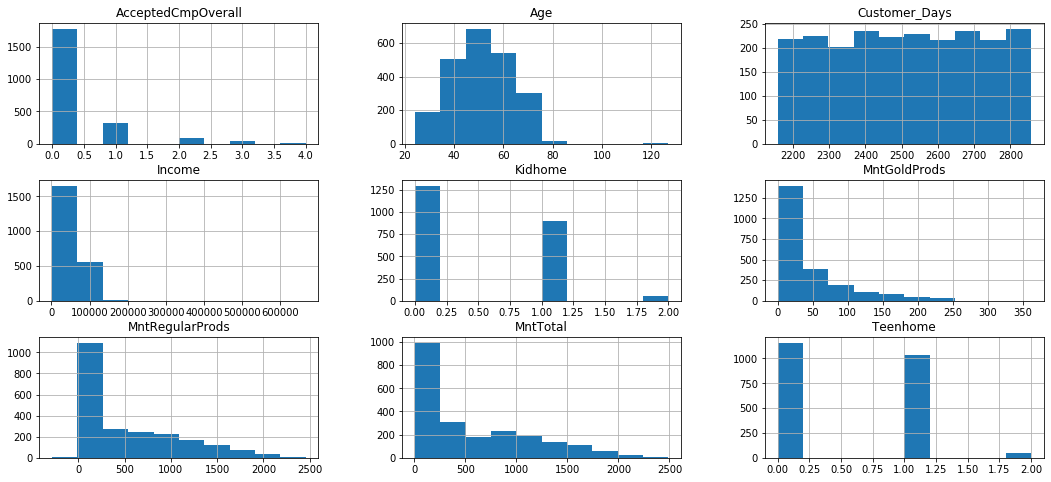

In [92]:
customer_ifood_df.hist( column = ['Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome', 'MntTotal', 'MntRegularProds', 'MntGoldProds', 'AcceptedCmpOverall'], figsize=(18,8))

## Outliers and missing data in Income and Age columns

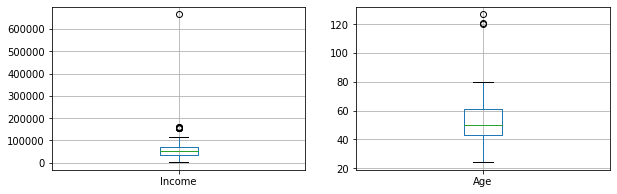

In [80]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

customer_ifood_df.boxplot(column=['Income'], ax=ax[0])
customer_ifood_df.boxplot(column=['Age'], ax=ax[1])

In [267]:
len(ifood_df) - len(ifood_df.dropna())
ifood_df = ifood_df.dropna()

In [270]:
Q1 = ifood_df.Income.quantile(0.25)
Q3 = ifood_df.Income.quantile(0.75)
IQR = Q3 - Q1

Income_outliers = ifood_df[ifood_df.Income > Q3 + 1.5*IQR]
ifood_df = ifood_df[ifood_df.Income < Q3 + 1.5*IQR]
Income_outliers.head()

ID    Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
164   8475  157243.0        0         1       98        20          2   
617   1503  162397.0        1         1       31        85          1   
655   5555  153924.0        0         0       81         1          1   
687   1501  160803.0        0         0       21        55         16   
1300  5336  157733.0        1         0       37        39          1   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  \
164              1582                1                 2  ...   
617                16                2                 1  ...   
655                 1                1                 1  ...   
687              1622               17                 3  ...   
1300                9                2                 0  ...   

      marital_Together  marital_Widow  education_2n Cycle  education_Basic  \
164                  0              0                   0                0   
617                  1              0                   0                0   
655                  0              0                   0                0   
687                  0              0                   0                0   
1300                 1              0                   0                0   

      education_Graduation  education_Master  education_PhD  MntTotal  \
164                      0                 0              1      1607   
617                      0                 0              1       105   
655                      1                 0              0         5   
687                      0                 0              1      1713   
1300                     0                 1              0        51   

      MntRegularProds  AcceptedCmpOverall  
164              1606                   0  
617               103                   0  
655                 4                   0  
687              1709                   0  
1300               43                   0  

[5 rows x 40 columns]

In [271]:
Q1 = ifood_df.Age.quantile(0.25)
Q3 = ifood_df.Age.quantile(0.75)
IQR = Q3 - Q1

Age_outliers = ifood_df[ifood_df.Age > Q3 + 1.5*IQR]
ifood_df = ifood_df[ifood_df.Age < Q3 + 1.5*IQR]
Age_outliers.head()

ID   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
192   7829  36640.0        1         0       99        15          6   
239  11004  60182.0        0         1       23         8          0   
339   1150  83532.0        0         0       36       755        144   

     MntMeatProducts  MntFishProducts  MntSweetProducts  ...  \
192                8                7                 4  ...   
239                5                7                 0  ...   
339              562              104                64  ...   

     marital_Together  marital_Widow  education_2n Cycle  education_Basic  \
192                 0              0                   1                0   
239                 0              0                   1                0   
339                 1              0                   0                0   

     education_Graduation  education_Master  education_PhD  MntTotal  \
192                     0                 0              0        40   
239                     0                 0              0        20   
339                     0                 0              1      1629   

     MntRegularProds  AcceptedCmpOverall  
192               15                   0  
239               18                   0  
339             1405                   1  

[3 rows x 40 columns]

## Features Correlation Analysis


In [272]:
corr = ifood_df.drop(['Z_CostContact', 'Z_Revenue'], axis=1).corr(method='spearman')
corr_mask = corr.mask(np.triu(np.ones_like(corr, dtype=np.bool)))
corr_unstacked = corr_mask.unstack().sort_values(ascending = False)

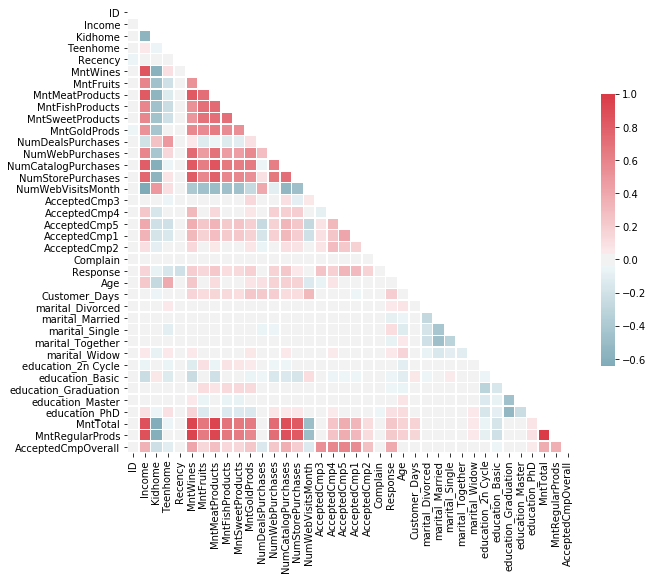

In [274]:
# Draw the heatmap with the mask and correct aspect ratio
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.subplots(figsize=(10,10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [275]:
pd.DataFrame(corr_unstacked[(abs(corr_unstacked)>0.8)&(abs(corr_unstacked)<1)]).sort_index().style.background_gradient(cmap='coolwarm', low=.5, high=-.7)

In [276]:
pd.DataFrame(corr_unstacked[corr_unstacked<-.5]).sort_index().style.background_gradient(cmap='coolwarm', low=-.6, high=.5)

### Correlation Results

Fish is more positively correlated with fruits (0.5948) than with wine (0.3998)
Parents having children or teenagers at home tend to spend less money in general but they also tend to purchase more using deals and to visit the website
Catalog seems like the channel where people use to spend more money in general
People who buy wine tend to accept more the campaigns
The number of web visits per month is negativelly correlated with the money spent by the custumer, as well as the custumer income


### Segmentation of Customers

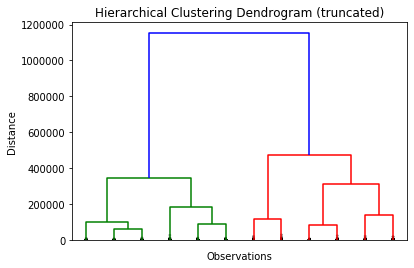

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

data_NumberClusters = ifood_df.drop(['Z_CostContact','Z_Revenue','Response'], axis=1)
data = linkage(data_NumberClusters, 'ward')

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Observations')
plt.ylabel('Distance')

dendrogram(
    data,
    truncate_mode='lastp',
    p=12,
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,)
plt.show()

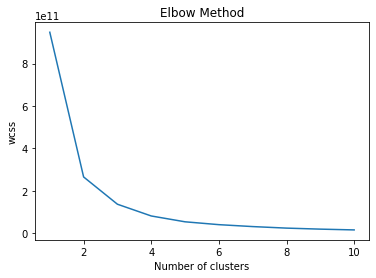

In [285]:
wcss = []
X = ifood_df.drop(['Z_CostContact','Z_Revenue','Response'], axis=1)
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [288]:
##Fitting kmeans to the dataset with k=4
km4=KMeans(n_clusters=3,init='k-means++', max_iter=300, n_init=10, random_state=0)
X['cluster'] = km4.fit_predict(X)

In [295]:
X.cluster.value_counts()

1    761
0    730
2    714
Name: cluster, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f36d28f9590>,
      dtype=object)

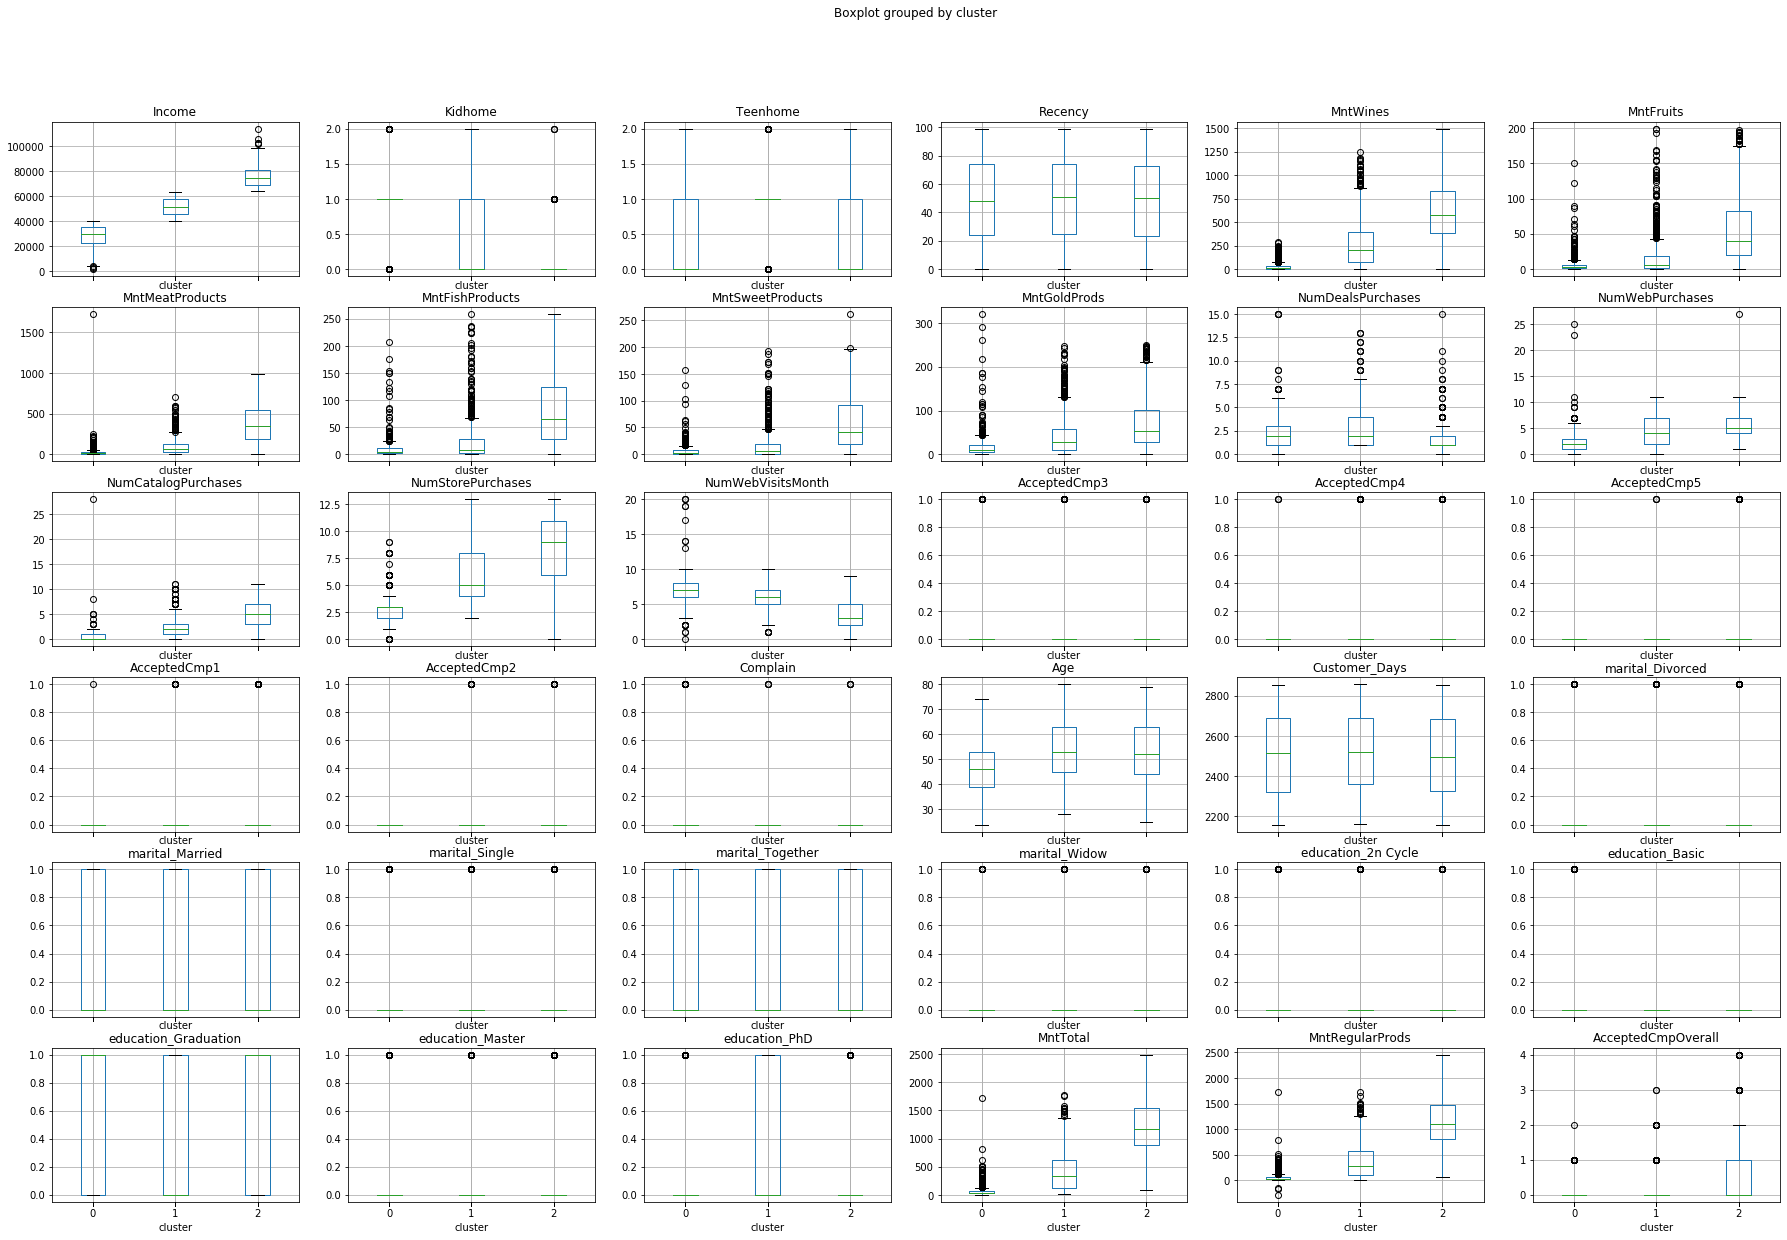

In [303]:
fig, axes = plt.subplots(6,6, sharex= True, sharey= False, figsize=(30,20))

X.boxplot(column=['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
'AcceptedCmpOverall'], ax = axes, by='cluster')

In [ ]:
#fig = px.parallel_coordinates(X_cluster, color="k")
#fig.show(figsize=(30,30))

In [297]:
ifood_df.columns

Index(['ID', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'],
      dtype='object')

In [298]:
len(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'])

37

In [282]:
(df.var())

NameError: name 'df' is not defined

In [20]:
df.Education.value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [13]:
df.describe(include=[np.number])

ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    23.750000     1.000000        16.000000   
50%      49.000000   173.500000     8.000000        67.000000   
75%      74.000000   504.250000    33.000000       232.000000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  ...  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
count      2240.000000  ...        2240.000000   2240.000000   2240.000000   
mean         37.525446  ...           5.316518      0.072768      0.074554   
std          54.628979  ...           2.426645      0.259813      0.262728   
min           0.000000  ...           0.000000      0.000000      0.000000   
25%           3.000000  ...           3.000000      0.000000      0.000000   
50%          12.000000  ...           6.000000      0.000000      0.000000   
75%          50.000000  ...           7.000000      0.000000      0.000000   
max         259.000000  ...          20.000000      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  \
count   2240.000000   2240.000000   2240.000000  2240.000000         2240.0   
mean       0.072768      0.064286      0.013393     0.009375            3.0   
std        0.259813      0.245316      0.114976     0.096391            0.0   
min        0.000000      0.000000      0.000000     0.000000            3.0   
25%        0.000000      0.000000      0.000000     0.000000            3.0   
50%        0.000000      0.000000      0.000000     0.000000            3.0   
75%        0.000000      0.000000      0.000000     0.000000            3.0   
max        1.000000      1.000000      1.000000     1.000000            3.0   

       Z_Revenue     Response  
count     2240.0  2240.000000  
mean        11.0     0.149107  
std          0.0     0.356274  
min         11.0     0.000000  
25%         11.0     0.000000  
50%         11.0     0.000000  
75%         11.0     0.000000  
max         11.0     1.000000  

[8 rows x 26 columns]

In [16]:
df.ID

0        5524
1        2174
2        4141
3        6182
4        5324
        ...  
2235    10870
2236     4001
2237     7270
2238     8235
2239     9405
Name: ID, Length: 2240, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74ce680510>,
      dtype=object)

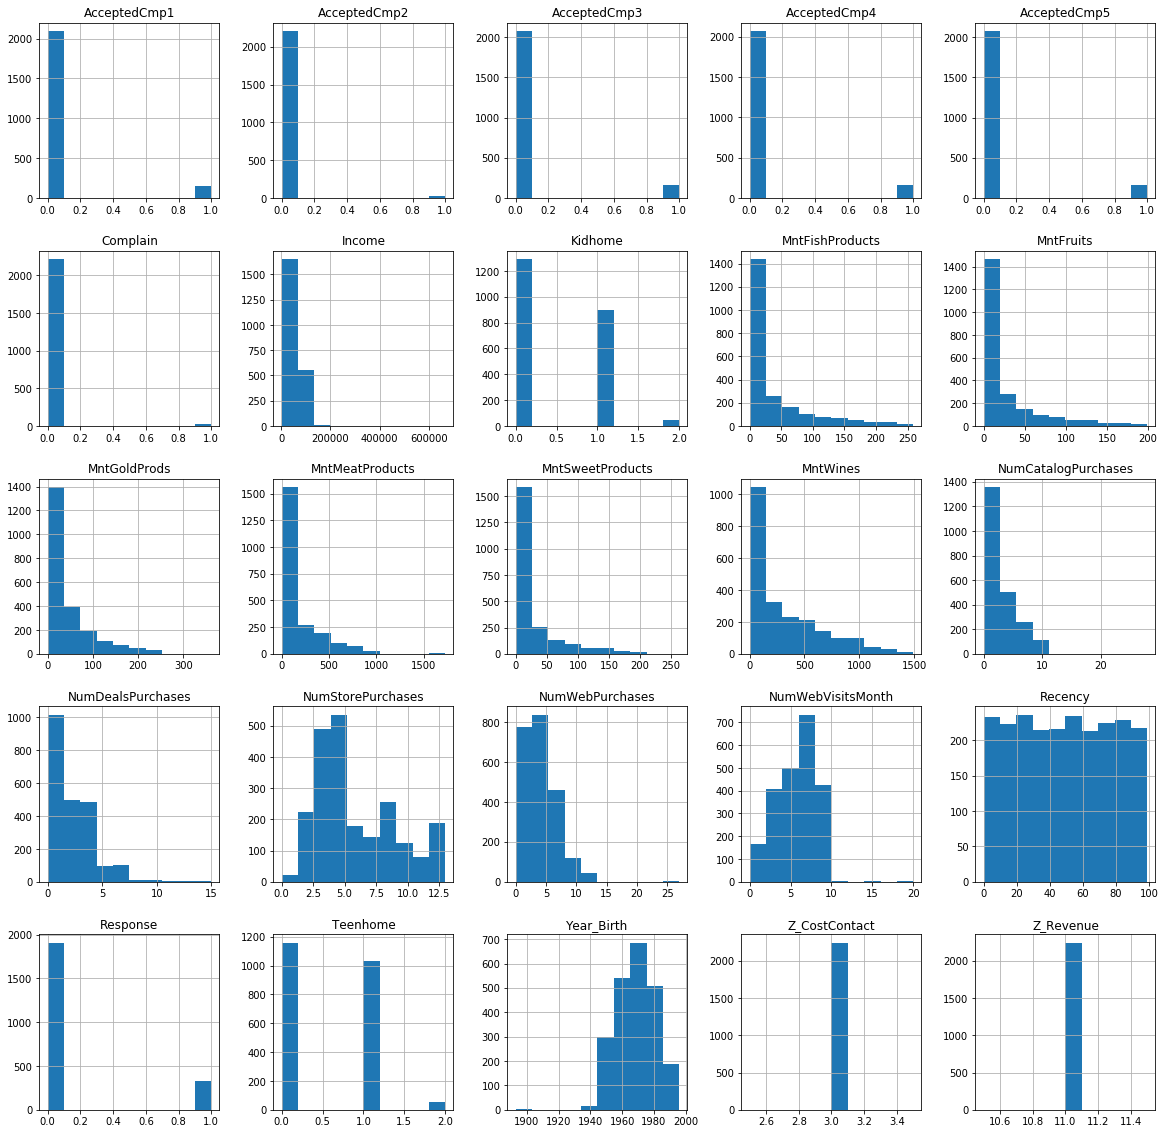

In [17]:
df.drop(['ID'], axis=1).hist(figsize=(20,20))

---
## Notes:

They sell products from 5 major categories: 
* wines
* rare meat products
* exotic fruits
* specially prepared fish
* sweet products

These can further be divided into: 
* gold
* regular products

3 sales channels: 
* physical stores
* catalogs
* website.

---
## Data dictionary
![alt text](dictionary.png "Title")